# CAPSTONE PROJECT 2: A COMPUTER VISION MODEL WHICH DETECTS BONE FRACTURES IN THE UPPER EXTREMITIES NAMELY: WRISTS, FOREARMS, UPPER ARM, & SHOULDER FRACTURES
#### Exploratory Data Analysis


***
Goal: Explore the data relationships of all your features and understand how the
features compare to the response variable. <br>
- Build data profiles and tables
    - Inferential statistics
- Explore data relationships
    - Data visualization
- Feature Selection and Engineering <br>
Inferential Statistics Hint: do any particular results in your data strike you as abnormal?<br>
What hypotheses can you form (Null and Alternative hypotheses) which you could go on
to test? <br>Take some time to recall your statistical concepts, such as that the p-value of an
observation is the probability of seeing data at least as extreme as that observation, on
the assumption of the null hypothesis.
Data Visualization Hint: recall your matplotlib and seaborn functions for data
visualization: <br> matplotlib:
- plt.plot()
- plt.xlabel()
- plt.show()
- plt.hist(), <br>
Seaborn: <br>
- sns.relplot()
- sns.lmplot()
- sns.catplot().
Remember to always start with an idea of what you want to achieve, and use these
libraries and their functions as your toolkit to make that idea a reality.
Feature Selection and Engineering Hint: feature selection is where data storytelling starts:
we tell a story as soon as we include certain features and omit others. But how we
manipulate - or engineer - those fields is just as important. <br>Recall the crucial elements to
feature engineering:
- If you have categorical features, you might need to one-hot encode them
- You may need to binarize your columns and bin your values.
- To handle missing data, think about how appropriate the methods of listwise
deletion, data imputation, replacing missing values with constants or simply
attempting to find the missing values are for your data.
- Think about whether you need to standardize, log-transform or normalize your
data, as well as statistically valid ways to remove outliers.<br>
Consider the following questions and use your understanding of your dataset to answer
them:<br>
- Are there variables that are particularly significant in terms of explaining the 
answer to your project question?
- Are there significant differences between subgroups in your data that may be
relevant to your project aim?
- Are there strong correlations between pairs of independent variables or between
an independent and a dependent variable?
- What are the most appropriate tests to use to analyze these relationships?
***

In [267]:
# Import modules:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Import any other relevent modules as they become necesary throughout the project.
import sklearn as skl
import skimage as ski
import cv2

# Image Analysis imports
from skimage.filters import sobel
from skimage import exposure
from skimage.filters import try_all_threshold
from skimage.filters import threshold_yen
from skimage import measure
from skimage.segmentation import slic

# PyTorch Analysis imports
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import albumentations as A
import torchvision
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.functional as F
torch.manual_seed(0)

In [268]:
#Import the data as Pandas DataFrames: df_test, df_train, df_val
data_links = [r'C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\df_test.csv', 
              r'C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\df_train.csv', 
              r'C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\df_val.csv']

def multi_df(list):
    temp_list = []
    for i in list:
        temp_list.append(pd.read_csv(i))
    return temp_list
    
df_test, df_train, df_val = multi_df(data_links)
    
    

In [269]:
# GLOBALS
# Project Main Directory path
dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2"

# Data Paths
train_dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\train"
val_dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\valid"
test_dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\test"

# Image Scalars
Width = 400
Height = 400

# Labels
num_classes = 7
classes=['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']
c2l={k:v for k,v in list(zip(classes,list(range(num_classes))))}
l2c={v:k for k,v in c2l.items()}


In [270]:
df_test.head()

,Unnamed: 0,images,labels,classes,class-num
0,0,distal-humerus-fracture-1_jpg.rf.831cb137cfcbd...,distal-humerus-fracture-1_jpg.rf.831cb137cfcbd...,humerus,4
1,1,image1_0_png.rf.99862308d714bff3f9c410adf5ca93...,image1_0_png.rf.99862308d714bff3f9c410adf5ca93...,humerus,4
2,2,image1_1000_png.rf.a53c5e186c03961bf88075c6e3e...,image1_1000_png.rf.a53c5e186c03961bf88075c6e3e...,humerus,4
3,3,image1_1015_png.rf.3b7320c3c40771fa5532bf713a7...,image1_1015_png.rf.3b7320c3c40771fa5532bf713a7...,humerus,4
4,4,image1_1015_png.rf.9181f8eb07451331e22381bacb3...,image1_1015_png.rf.9181f8eb07451331e22381bacb3...,humerus,4


In [271]:
df_train.head()

,Unnamed: 0,images,labels,classes,class-num
0,0,distal-humeral-fractures-2-_JPEG.rf.39ba3f5304...,distal-humeral-fractures-2-_JPEG.rf.39ba3f5304...,elbow positive,0
1,1,distal-humeral-fractures-2-_JPEG.rf.525ce87678...,distal-humeral-fractures-2-_JPEG.rf.525ce87678...,elbow positive,0
2,2,distal-humeral-fractures-2-_JPEG.rf.f9442db05e...,distal-humeral-fractures-2-_JPEG.rf.f9442db05e...,elbow positive,0
3,3,elbow-dislocation-with-coronoid-process-fractu...,elbow-dislocation-with-coronoid-process-fractu...,elbow positive,0
4,4,elbow-dislocation-with-coronoid-process-fractu...,elbow-dislocation-with-coronoid-process-fractu...,elbow positive,0


In [272]:
df_val.head()

,Unnamed: 0,images,labels,classes,class-num
0,0,coronoid-process-fracture_jpg.rf.71650459c69a9...,coronoid-process-fracture_jpg.rf.71650459c69a9...,elbow positive,0
1,1,image1_0_png.rf.d29cab92b154a83ca5bf7e40083673...,image1_0_png.rf.d29cab92b154a83ca5bf7e40083673...,fingers positive,1
2,2,image1_1000_png.rf.7eebc2918f75be5baf4c32a091e...,image1_1000_png.rf.7eebc2918f75be5baf4c32a091e...,fingers positive,1
3,3,image1_1026_png.rf.e9dc3004de762ddd0f75d8f17fb...,image1_1026_png.rf.e9dc3004de762ddd0f75d8f17fb...,fingers positive,1
4,4,image1_1029_png.rf.8f1dfb1982511a9b38867fa9444...,image1_1029_png.rf.8f1dfb1982511a9b38867fa9444...,fingers positive,1


These csv files double importet their indices so we will appropriately trim them.

In [273]:
df_train.drop(columns='Unnamed: 0', inplace=True)
df_test.drop(columns='Unnamed: 0', inplace=True)
df_val.drop(columns='Unnamed: 0', inplace=True)

Also just to make sure, we will import an image and superimpose it's respective label to make sure we can still use this data from the data wrangling portion of the project.

In [274]:
# IMAGE FUNCTIONS FOR ANALYSIS
# A function for preparing images for analysis:
def img_import(img_path, height=Height, width=Width):
    image = cv2.imread(img_path)
    image = cv2.resize(image,(height,width))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    return image, image_gray

       

# a function for displaying an image for EDA (Borrowed from DataCamp Course: Make Images Come Alive with SciKit-Image)
def img_render(img_path, tar_path, cmap_type='gray', height=Height, width=Width):
    # Read and scale image data
    image, image_gray = img_import(img_path, height, width)
    
    # Read target path
    file = open(tar_path, 'r')
    
    # Set up bbox
    bbox = bboxes(file)
    for box in bbox['bboxes']:
        xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
        sp, ep=(xmin, ymin), (xmax, ymax)
        image = cv2.rectangle(image, sp, ep, (0, 255, 0), 2)
    
    # Display Image
    plt.imshow(image, cmap=cmap_type)
    plt.title(l2c[bbox['label']])
    plt.axis('off')
    plt.show()
    
# function which converts the albumentated values back to 'pascal voc' representation
def to_pascal(width, height, x, y, w, h):

    xmax = int((x*width) + (w * width)/2.0)
    xmin = int((x*width) - (w * width)/2.0)
    ymax = int((y*height) + (h * height)/2.0)
    ymin = int((y*height) - (h * height)/2.0)

    return xmin, ymin, xmax, ymax

# access label and bbox data, convert to drawable values and store in bbox variable.
def bboxes(file, i=1):
    target=list(map(float,file.read().split()))
    print(target)
    bbox = []
    while i < len(target):
        x, y, w, h = target[i:i+4]
        bbox.append([x, y, w, h])
        i += 4
        
    for box in bbox:
        xmin, ymin, xmax, ymax = to_pascal(Width, Height, box[0], box[1], box[2], box[3])
        box[0:4] = [xmin, ymin, xmax, ymax]
    
    bbox = {'label': int(target[0]),
            'bboxes': bbox}
    print(bbox)
     
    return bbox

# A function that gets basic image data and assigns it to it's respective row in a DataFrame
def img_basics(df, path):
    df['image_shape'] = None
    df['image_size'] = None
    i = 0
    while i < len(df):
        img_file = rf"{path}\images\{df['images'].iloc[i]}"
        img = cv2.imread(img_file)
        df['image_shape'].iloc[i] = img.shape
        df['image_size'].iloc[i] = img.size
        i += 1
        
# A function for just displaying an image
def show_image(image, cmap_type, title='image'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

# A function for selecting Random images from a DataFrame    
def random_image_select(df, path):
    length = len(df)
    index = np.random.randint(0, length)
    i_file = rf"{path}\images\{df['images'].iloc[index]}"
    file = rf"{path}\labels\{df['labels'].iloc[index]}"
    return i_file, file

# A Function for rendering features in selected images.
def feature_render(img_path, tar_path, height=Height, width=Width):
    # Import images as color and grayscale
    image, image_gray = img_import(img_path, height, width)
    
    # Feature extraction
    eq_image = exposure.equalize_adapthist(image_gray, clip_limit=0.03)
    thresh = threshold_yen(eq_image)
    binary = eq_image >= thresh
    contours = measure.find_contours(binary, 0.000001)
    segs = slic(eq_image, n_segments=1800)
    seg_image = ski.color.label2rgb(segs, eq_image, kind='avg')
    
    # Display Images
    fig1, axes = plt.subplots(nrows=1, ncols=5,
                         sharey=True,
                         figsize=(20, 20))
    axes[0].imshow(image, cmap=plt.cm.gray)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title('Original image')

    axes[1].imshow(eq_image, cmap=plt.cm.gray)
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_title('Enhanced Image')

    axes[2].imshow(binary, cmap=plt.cm.gray)
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    axes[2].set_title('Yen Thresholding')

    axes[3].imshow(binary, cmap=plt.cm.gray)
    for contour in contours:
        axes[3].plot(contour[: , 1], contour[:, 0], linewidth=2)
    axes[3].axis('image')
    axes[3].set_xticks([])
    axes[3].set_yticks([])
    axes[3].set_title('Contours')

    axes[4].imshow(seg_image)
    axes[4].set_xticks([])
    axes[4].set_yticks([])
    axes[4].set_title('Segmented Image')

    plt.show()
    
####################################################################################
### PyTorch Analysis Functions: ####################################################
####################################################################################
  
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def import_boxes(list):
    '''
    Function for converting the text data in the labels files into functional
    dictionaries:  Given a list from a read file it converts that list and 
    returns a dictionary with correlated label and coordinate data.
    '''
    # Convert strings to ints and floats
    for i in range(0, len(list)):
        if len(list[i]) == 1:
            list[i] = int(float(list[i]))
        else:
            list[i] = float(list[i])
    # initialize variables        
    boxes = {'labels': [],
              'coords': []}
    i = -1
    neg_len = len(list) - (len(list) * 2)
    temp_list = []
    # Convert list to a functional dictionary of labels and coords
    while i >=  neg_len:
        if type(list[i]) == int:
            boxes['labels'].append(list[i])
            boxes['coords'].append(temp_list)
            temp_list = []
        else:
            temp_list.insert(0, list[i])
        i -= 1
    
    return boxes


In [275]:
# access image file path and store in image variable
i_file = rf"{train_dir_path}\images\{df_train['images'].iloc[0]}"

# access target file for bboxes and labels
file = rf"{train_dir_path}\labels\{df_train['labels'].iloc[0]}"

[0.0, 0.35585933923721313, 0.3968750014901161, 0.4525467435362568, 0.3829741733292004, 0.4556711770844495, 0.47362547689055823, 0.3681857266505504, 0.48925501404327343]
{'label': 0, 'bboxes': [[51, 82, 232, 235], [108, 91, 255, 287]]}


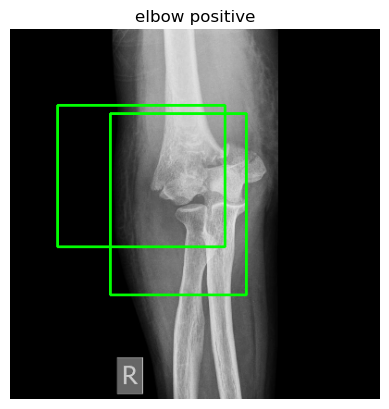

In [276]:
img_render(i_file, file)

Excellent! Now to begin analysis of our DataFrame contents:
- General shape and count values of data: train, test, validation
- image content analysis:
    - image contrast improvement for better visibility
    - angle detection
    - border detection

In [277]:
df_train.shape

(3631, 4)

In [278]:
img_basics(df_train, train_dir_path)

C:\Users\micha\AppData\Local\Temp\ipykernel_10324\2703558099.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_shape'].iloc[i] = img.shape
C:\Users\micha\AppData\Local\Temp\ipykernel_10324\2703558099.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_size'].iloc[i] = img.size


In [279]:
img_basics(df_test, test_dir_path)

C:\Users\micha\AppData\Local\Temp\ipykernel_10324\2703558099.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_shape'].iloc[i] = img.shape
C:\Users\micha\AppData\Local\Temp\ipykernel_10324\2703558099.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_size'].iloc[i] = img.size


In [280]:
img_basics(df_val, val_dir_path)

C:\Users\micha\AppData\Local\Temp\ipykernel_10324\2703558099.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_shape'].iloc[i] = img.shape
C:\Users\micha\AppData\Local\Temp\ipykernel_10324\2703558099.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_size'].iloc[i] = img.size


In [281]:
df_train.head()

,images,labels,classes,class-num,image_shape,image_size
0,distal-humeral-fractures-2-_JPEG.rf.39ba3f5304...,distal-humeral-fractures-2-_JPEG.rf.39ba3f5304...,elbow positive,0,"(1024, 1024, 3)",3145728
1,distal-humeral-fractures-2-_JPEG.rf.525ce87678...,distal-humeral-fractures-2-_JPEG.rf.525ce87678...,elbow positive,0,"(1024, 1024, 3)",3145728
2,distal-humeral-fractures-2-_JPEG.rf.f9442db05e...,distal-humeral-fractures-2-_JPEG.rf.f9442db05e...,elbow positive,0,"(1024, 1024, 3)",3145728
3,elbow-dislocation-with-coronoid-process-fractu...,elbow-dislocation-with-coronoid-process-fractu...,elbow positive,0,"(2048, 2048, 3)",12582912
4,elbow-dislocation-with-coronoid-process-fractu...,elbow-dislocation-with-coronoid-process-fractu...,elbow positive,0,"(2048, 2048, 3)",12582912


In [282]:
df_test.head()

,images,labels,classes,class-num,image_shape,image_size
0,distal-humerus-fracture-1_jpg.rf.831cb137cfcbd...,distal-humerus-fracture-1_jpg.rf.831cb137cfcbd...,humerus,4,"(2048, 801, 3)",4921344
1,image1_0_png.rf.99862308d714bff3f9c410adf5ca93...,image1_0_png.rf.99862308d714bff3f9c410adf5ca93...,humerus,4,"(379, 512, 3)",582144
2,image1_1000_png.rf.a53c5e186c03961bf88075c6e3e...,image1_1000_png.rf.a53c5e186c03961bf88075c6e3e...,humerus,4,"(420, 512, 3)",645120
3,image1_1015_png.rf.3b7320c3c40771fa5532bf713a7...,image1_1015_png.rf.3b7320c3c40771fa5532bf713a7...,humerus,4,"(425, 512, 3)",652800
4,image1_1015_png.rf.9181f8eb07451331e22381bacb3...,image1_1015_png.rf.9181f8eb07451331e22381bacb3...,humerus,4,"(512, 497, 3)",763392


In [283]:
df_val.head()

,images,labels,classes,class-num,image_shape,image_size
0,coronoid-process-fracture_jpg.rf.71650459c69a9...,coronoid-process-fracture_jpg.rf.71650459c69a9...,elbow positive,0,"(1355, 1409, 3)",5727585
1,image1_0_png.rf.d29cab92b154a83ca5bf7e40083673...,image1_0_png.rf.d29cab92b154a83ca5bf7e40083673...,fingers positive,1,"(512, 236, 3)",362496
2,image1_1000_png.rf.7eebc2918f75be5baf4c32a091e...,image1_1000_png.rf.7eebc2918f75be5baf4c32a091e...,fingers positive,1,"(512, 153, 3)",235008
3,image1_1026_png.rf.e9dc3004de762ddd0f75d8f17fb...,image1_1026_png.rf.e9dc3004de762ddd0f75d8f17fb...,fingers positive,1,"(394, 512, 3)",605184
4,image1_1029_png.rf.8f1dfb1982511a9b38867fa9444...,image1_1029_png.rf.8f1dfb1982511a9b38867fa9444...,fingers positive,1,"(406, 512, 3)",623616


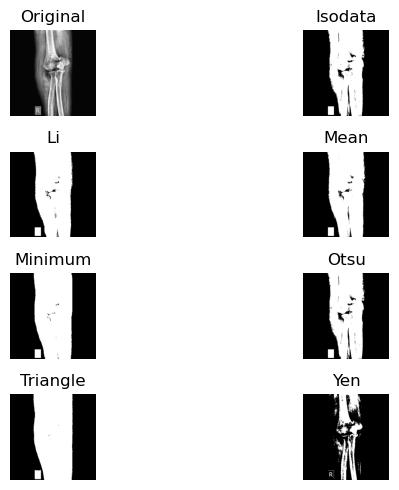

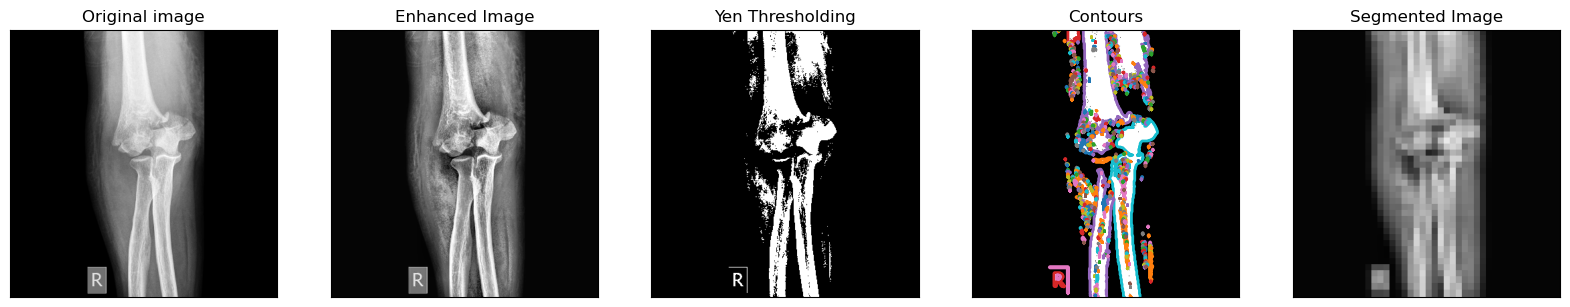

In [284]:
# Import file for testing
image = cv2.imread(i_file)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
image = cv2.resize(image, (Height,Width))

# Obtain all the resulting images
eq_image = exposure.equalize_adapthist(image, clip_limit=0.03)
edge_sobel = sobel(eq_image)

# threshold and contours
fig, ax = try_all_threshold(eq_image, verbose=False)
plt.show()

thresh = threshold_yen(eq_image)
binary = eq_image >= thresh

contours = measure.find_contours(binary, 0.000001)

#Segmentation
segs = slic(eq_image, n_segments=1800)
seg_image = ski.color.label2rgb(segs, eq_image, kind='avg')

# Showing resulting plots
fig1, axes = plt.subplots(nrows=1, ncols=5,
                         sharey=True,
                         figsize=(20, 20))
axes[0].imshow(image, cmap=plt.cm.gray)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Original image')

axes[1].imshow(eq_image, cmap=plt.cm.gray)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Enhanced Image')

axes[2].imshow(binary, cmap=plt.cm.gray)
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title('Yen Thresholding')

axes[3].imshow(binary, cmap=plt.cm.gray)
for contour in contours:
    axes[3].plot(contour[: , 1], contour[:, 0], linewidth=2)
axes[3].axis('image')
axes[3].set_xticks([])
axes[3].set_yticks([])
axes[3].set_title('Contours')

axes[4].imshow(seg_image)
axes[4].set_xticks([])
axes[4].set_yticks([])
axes[4].set_title('Segmented Image')

plt.show()



Cool. So to a certain extent features can be extracted from these images, unfortunately however,  if our purposes is to create a general purpose model for fracture detection and classification, then these methods of feature extrapolation  aren't going to be of much service to us in this context. simply from the nature of x-ray imaging and the complexity of the images we are presenting.  Therefore it is all too likely that we will need to generate feature sets using Tensors in pytorch, where patterns can be extrapolated more efficiently, clearly and a model can be trained.  With that being said it could be worth our time to add these features to our data set, namely: the Yen Threshold value, and the contours, both their values and their lengths.

So we will run all of these renderings again on a random set of 15 images in the DataFrame to make sure it will behave consistently before adding those feature sets to their respective data Frames.

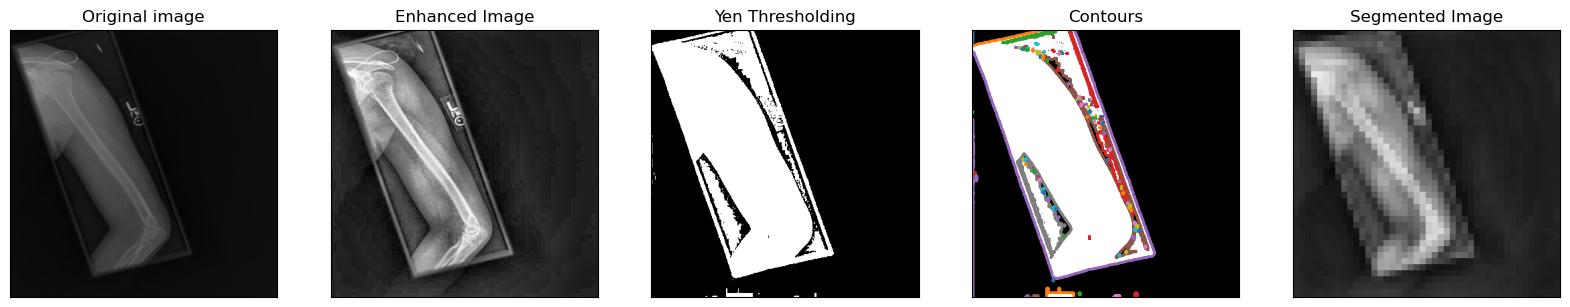

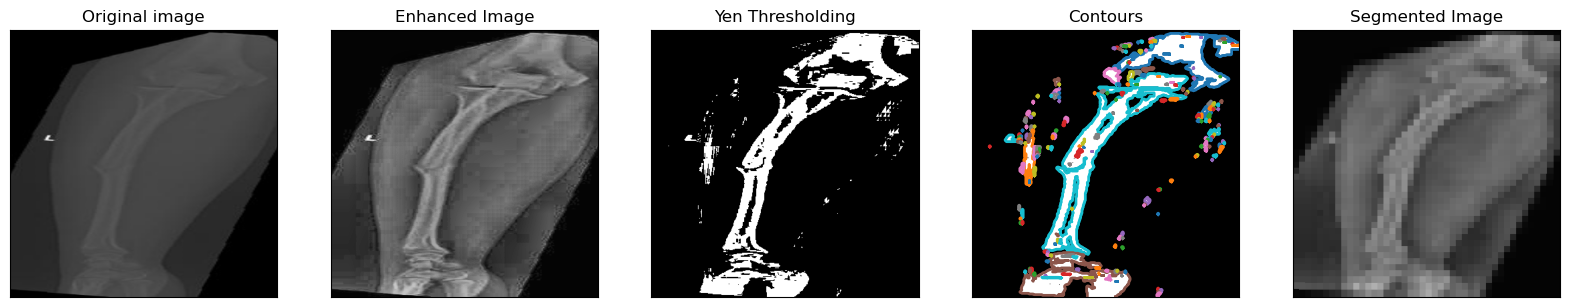

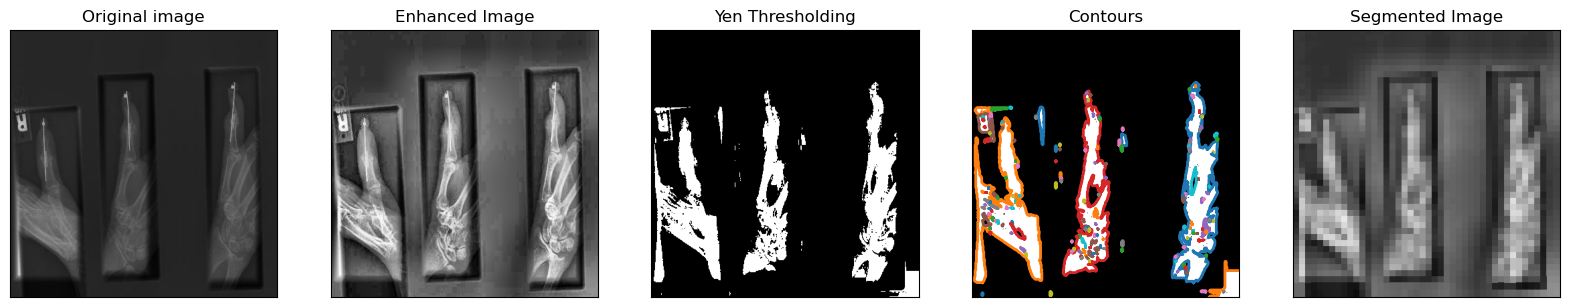

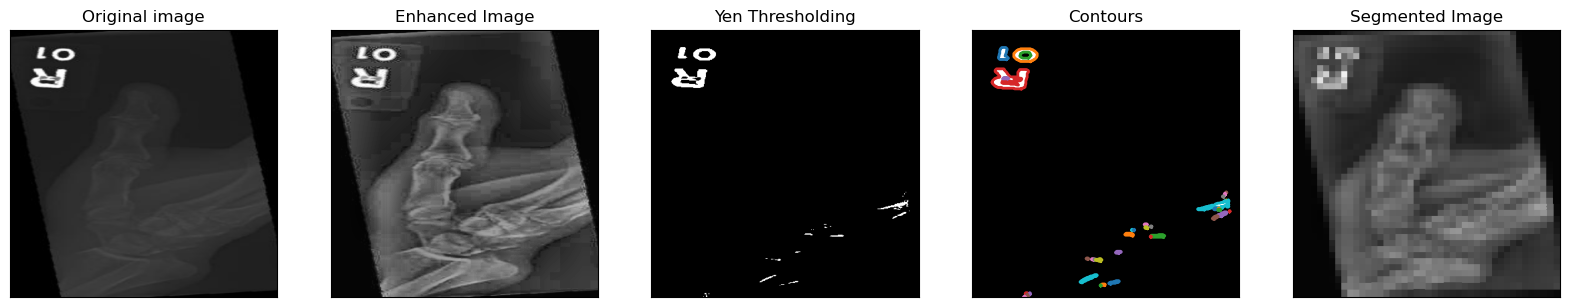

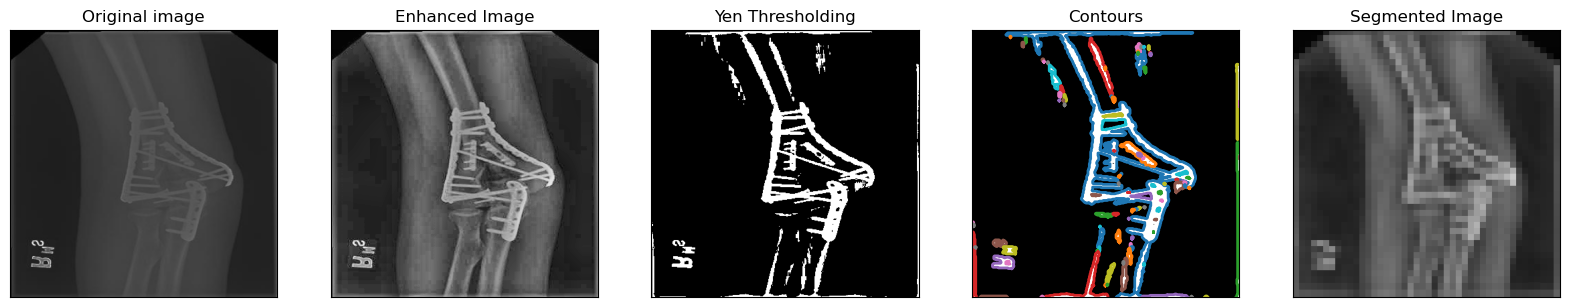

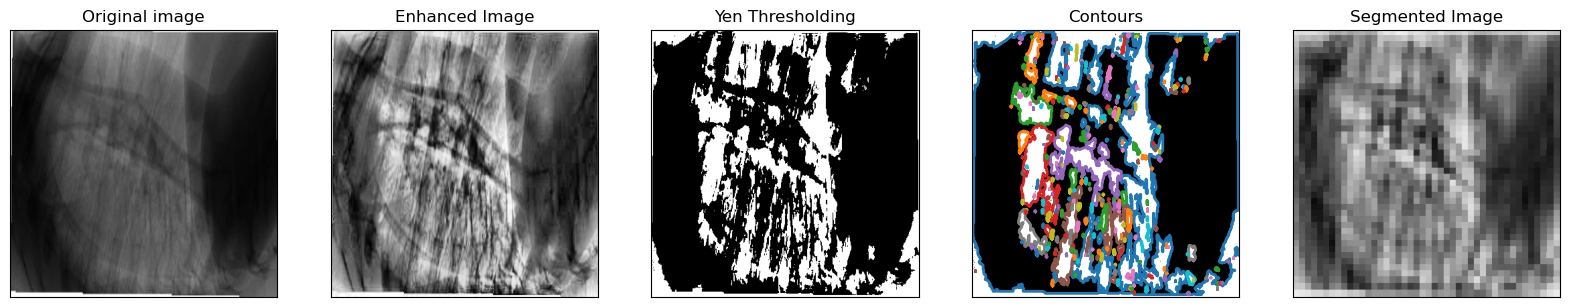

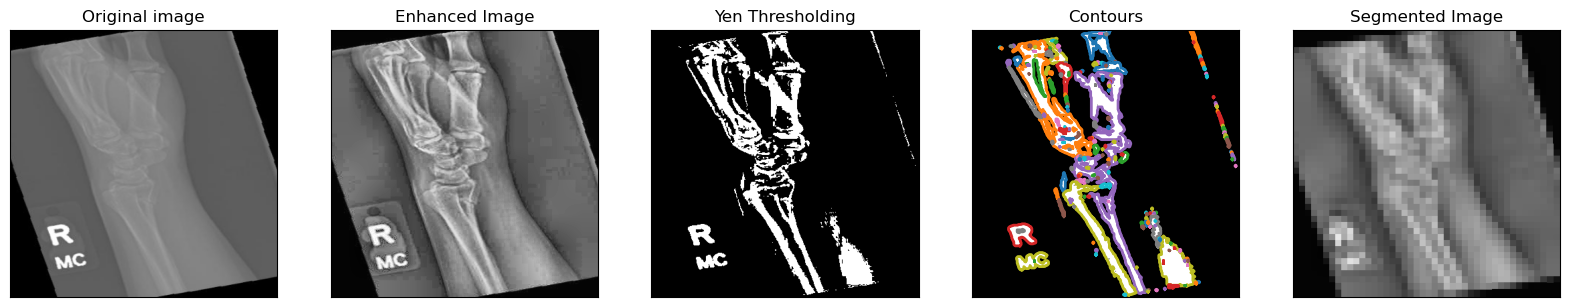

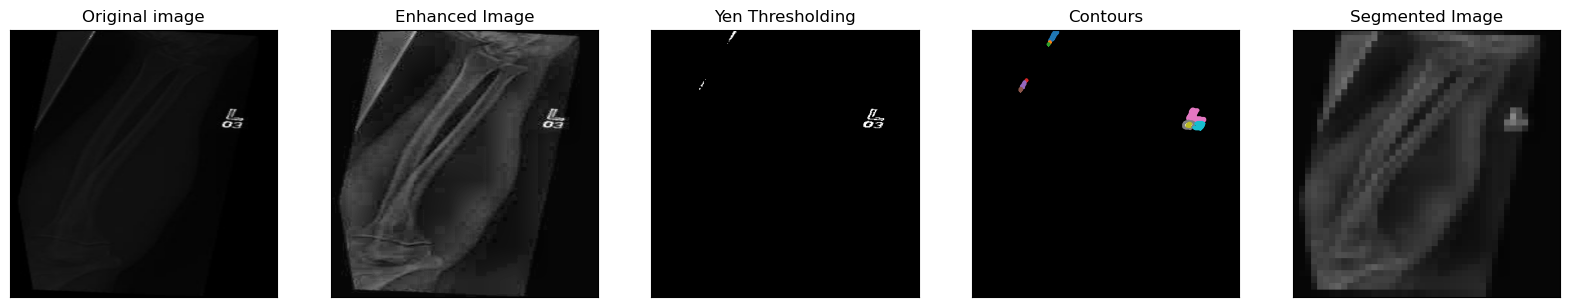

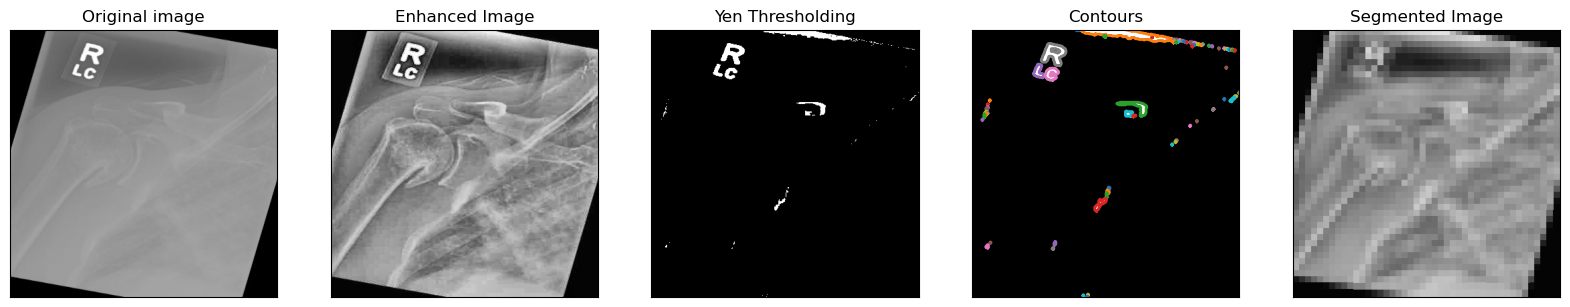

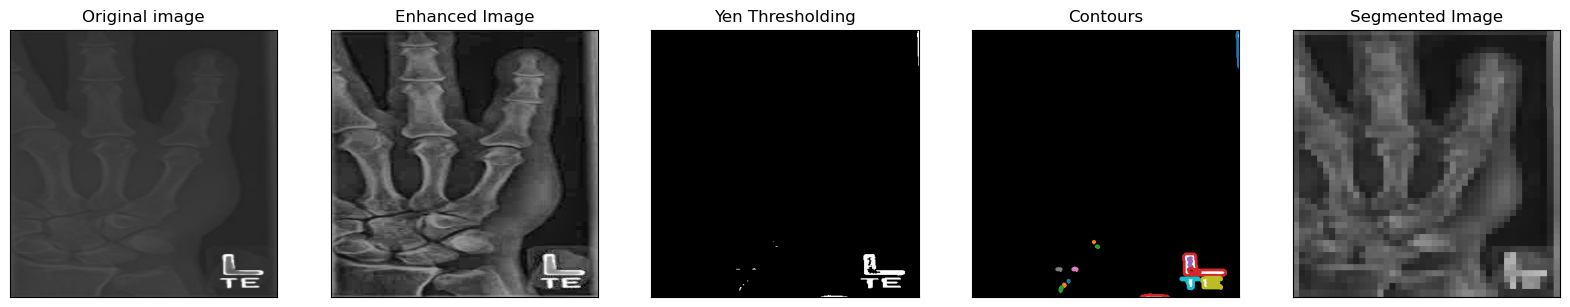

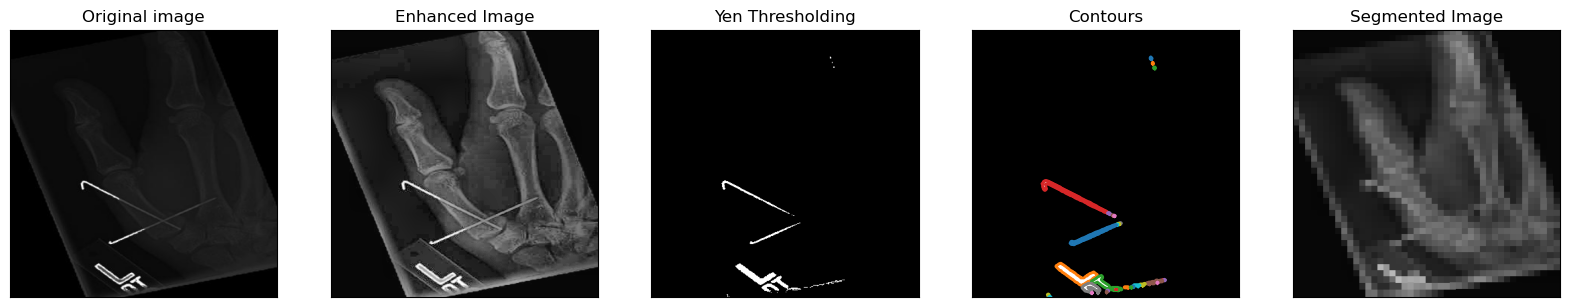

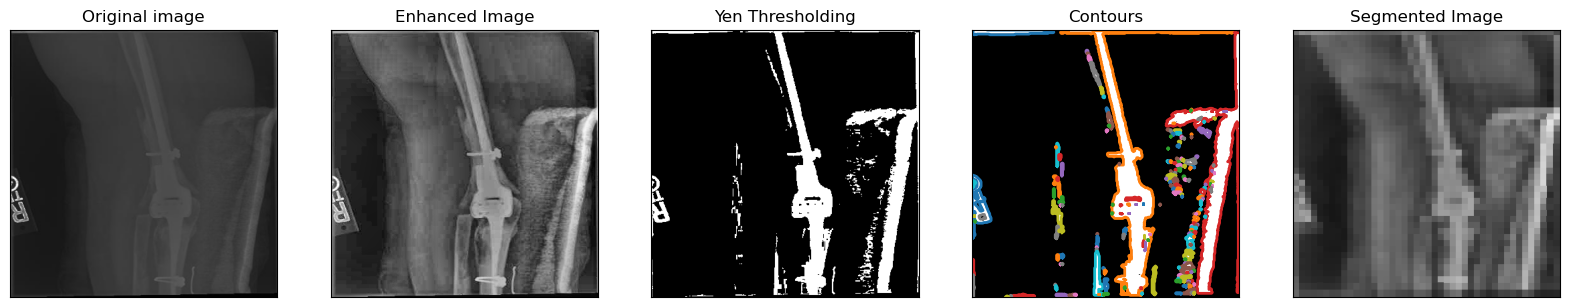

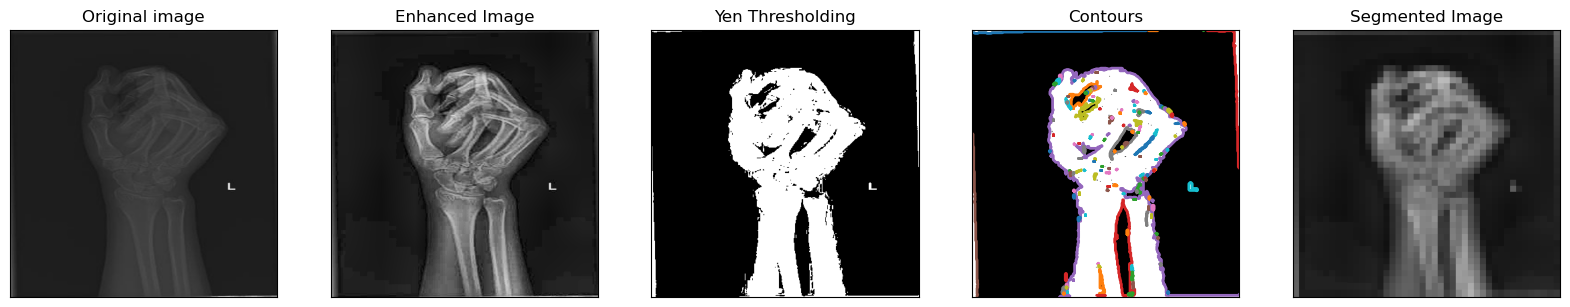

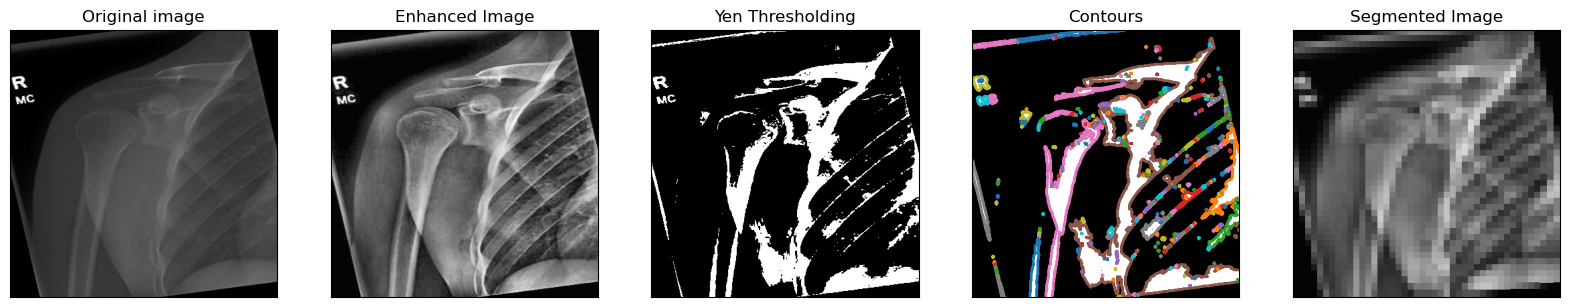

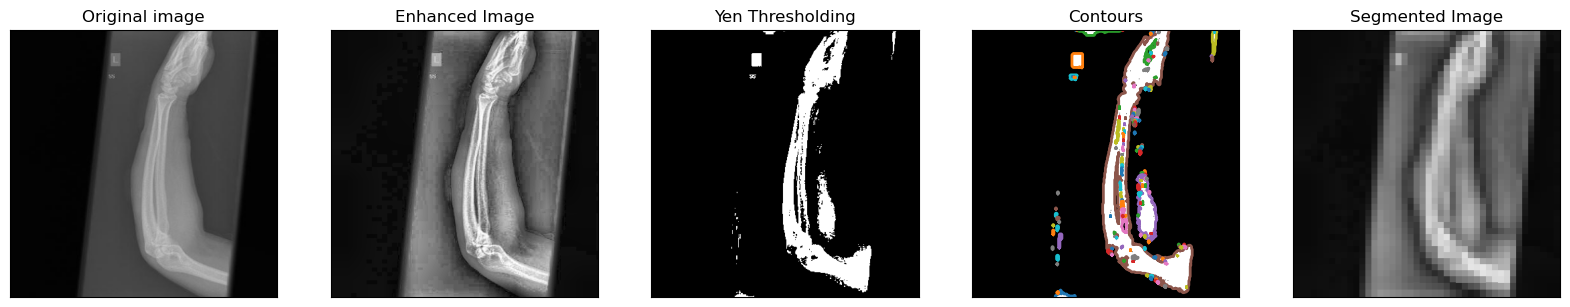

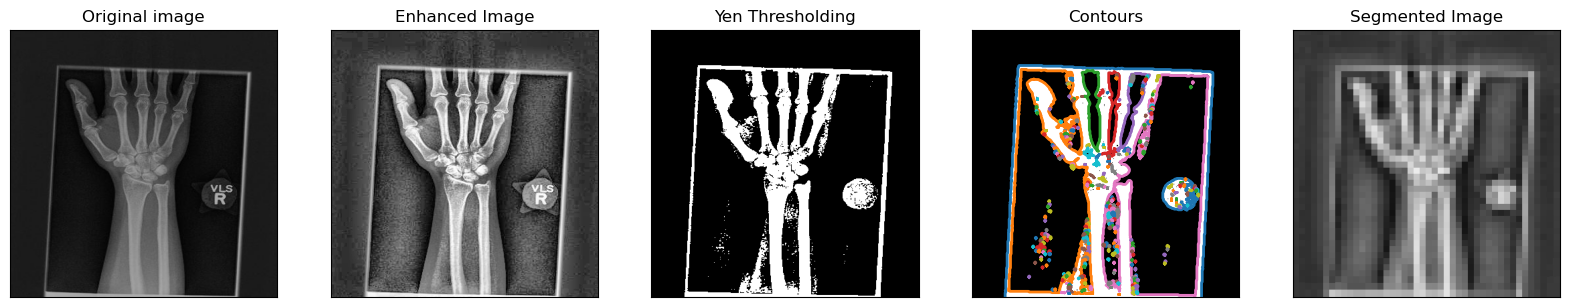

In [285]:
np.random.seed(1234)

for i in np.arange(16):
    i_file, file = random_image_select(df_train, train_dir_path)
    feature_render(i_file, file)

It appears that Yen doesn't universally apply to well to all the images.  Therefore It would be difficult to add these feature in the image data to the DataFrames.  It is therefore with heavy heart that I move on to generating Computer vision features using PyTorch.  Also my current Approach to bounding boxes doesn't accomodate for all circumstances so we will need to convert the DataFrames into Tensors and proceed forward with a different approach to the EDA.

We will be borrowing heavily from the previous work done on these kaggle projects:

https://www.kaggle.com/code/sivashankarans/fracture-detection-torch-faster-rcnn 
<br>
https://www.kaggle.com/code/rodrigoazs/reading-files-and-plotting-bounding-boxes


In [286]:
import os
from torch.utils.data import Dataset
from PIL import Image

In [287]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.transform = transform
        self.files = [rf"{root}\Data\{mode}\images\{name}" for name in os.listdir(root + rf"\Data\{mode}\images") if name.endswith(".jpg")]
        self.labels = {}
        self.boxes = {}
        assert len(self.files) > 0, "Make sure you downloaded the images!"

    def get_image(self, index):
        item = self.transform(Image.open(self.files[index % len(self.files)]))
        if item.shape[0] != 3: 
            item = item.repeat(3, 1, 1)
        # Old versions of PyTorch didn't support normalization for different-channeled images
        return item
    
    def get_labels(self, index):
        if index in self.labels:
            return self.labels[index]
        labels = []
        boxes = []
        text_file = self.files[index % len(self.files)].replace(".jpg", ".txt").replace("images", "labels")
        with open(text_file, mode="r") as f:
            lines = f.readlines()
            for line in lines:
                values = [value for value in line.split()]
                bboxes = import_boxes(values)
                for i in range(0, len(bboxes['labels'])):
                    coords = bboxes['coords'][i]
                    coords = torch.reshape(torch.FloatTensor(coords), (int(len(coords)/2), 2))
                    size = torch.tensor([self.get_image(index).shape[2], self.get_image(index).shape[1]])
                    min_coords = torch.min(coords, dim=0).values * size
                    max_coords = torch.max(coords, dim=0).values * size
                    box = torch.cat((min_coords, max_coords), dim=0).tolist()
                    labels.append(l2c[bboxes['labels'][i]])
                    boxes.append(box)
        self.labels[index] = labels
        self.boxes[index] = torch.ByteTensor(boxes)
        return labels
    
    def get_boxes(self, index):
        if index in self.boxes:
            return self.boxes[index]
        _ = self.get_labels(index)
        return self.boxes[index]

    def __len__(self):
        return len(self.files)

In [297]:
load_shape = 384

transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.ToTensor(),
])

tnsor_train = ImageDataset(dir_path, transform=transform)

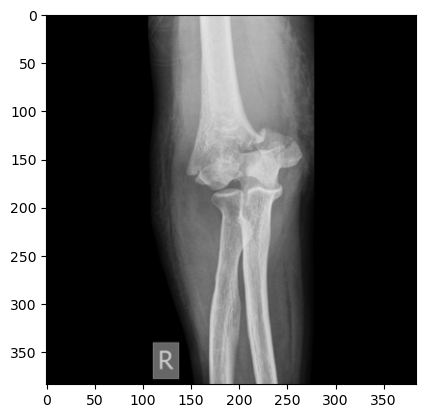

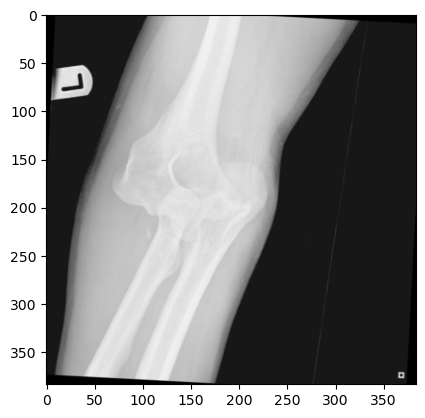

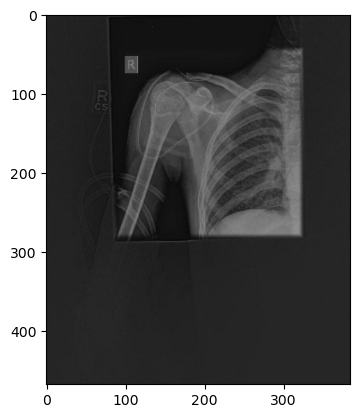

In [298]:
show_tensor_images(tnsor_train.get_image(0), num_images=1, size=(3, 384, 384))
show_tensor_images(tnsor_train.get_image(5), num_images=1, size=(3, 384, 384))
show_tensor_images(tnsor_train.get_image(1264), num_images=1, size=(3, 468, 384))

RuntimeError: value cannot be converted to type uint8 without overflow

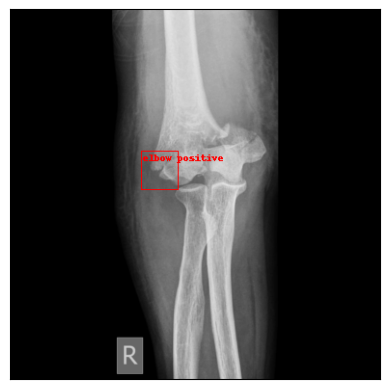

In [299]:
for index in [0, 8, 5, 1264, 876, 15]:
    img = transforms.functional.convert_image_dtype(tnsor_train.get_image(index), dtype=torch.uint8)
    drawn_boxes = draw_bounding_boxes(img, tnsor_train.get_boxes(index), colors="red", labels=[str(x) for x in tnsor_train.get_labels(index)])
    show(drawn_boxes)